# CALIPSO Ozone Number Density

## Summary

## Note
By: Cheyenne Land

Tested using Python 3.8.10

## 1. Setup

In [ ]:
from pyhdf.SD import SD, SDC
import numpy as np
from matplotlib import pyplot as PLT

## 2. Open and read file

In [ ]:
data_file = 'CAL_LID_L1-Standard-V4-11.2021-04-01T00-29-13ZN.hdf'
hdf = SD(data_file, SDC.READ)
ds = hdf.datasets()

## 3. Retrieve data

Ozone_number_density [# of single shot (333m) resn profiles in file (55725), met_data_altitude (33)]

In [ ]:
hdfdataobject = hdf.select('Ozone_Number_Density')
latitude = hdf.select('Latitude')
data = hdfdataobject.get()
ozone_number_density = np.transpose(data)
lat = latitude.get()[:,0]

## 4. Create interval for altitude to plot on the y-axis.

Range is from -2 km - 40 km of 33 range bins.
   For more detail go to CALIPSO Data Products Catalog at
   https://www-calipso.larc.nasa.gov/products/CALIPSO_DPC_Rev4x93.pdf

In [ ]:
met_data_altitudes = np.linspace(-2,40,33)

## 5. Generate plot

In [ ]:
PLT.figure(figsize=(7.20,3.60))
im = PLT.contourf(lat, met_data_altitudes, ozone_number_density,
                  cmap=PLT.get_cmap('jet'))
PLT.title('CAL_LID_L1-Standard-V4-11.2021-04-01T00-29-13ZN Ozone Number Density',
fontsize=8)
PLT.ylabel("Altitude (km)", fontsize = 8)
PLT.xlabel("Latitude (deg)", fontsize = 8)
cb = PLT.colorbar(im , shrink=0.90)
cb.set_label('Ozone Number Denisty m-³', fontsize=8)

## 6. Save the figure in your current directory

In [ ]:
# PLT.savefig("CAL_LID_L1-Standard-V4-11.2021-04-01T00-29-13ZN_Ozone_Number_Density.jpg",
# dpi=200)
# PLT.close()

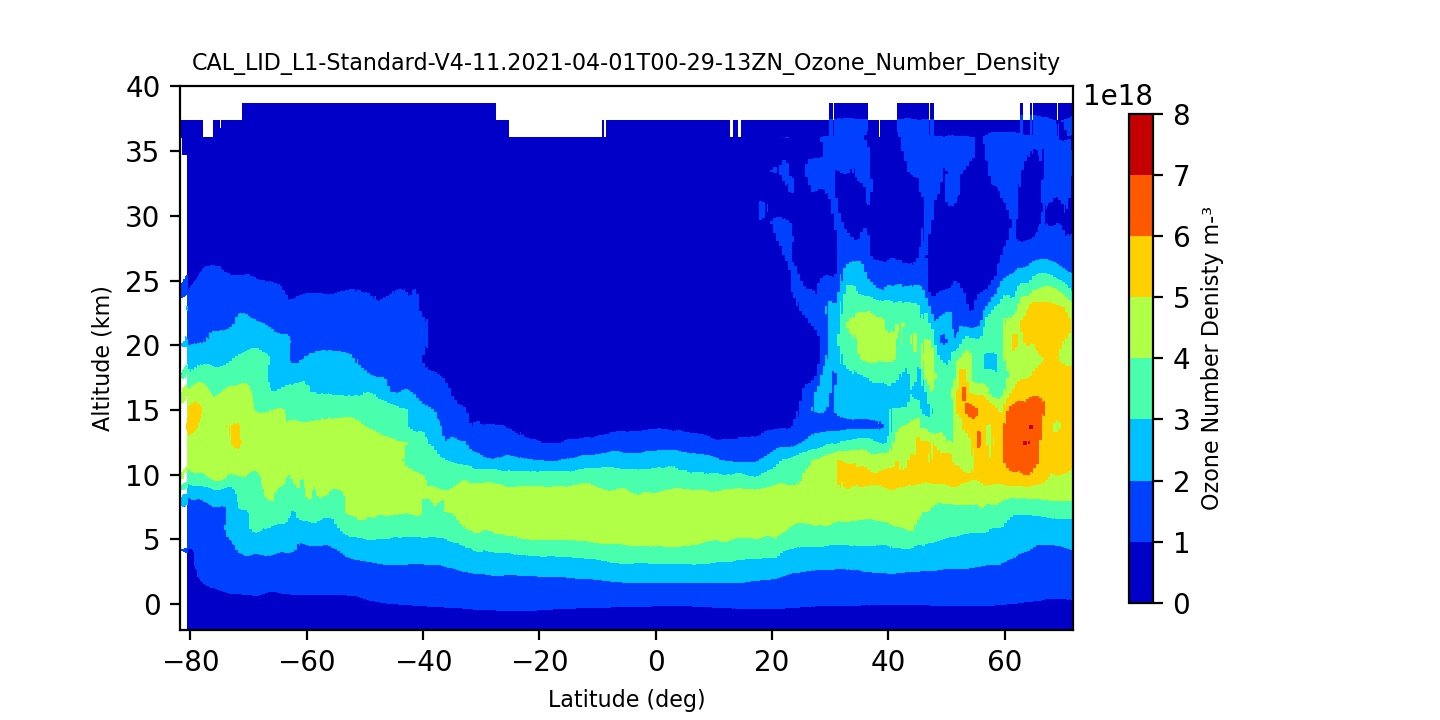